In [261]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [262]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [263]:
print(train_df.head())
print(train_df.info())
print(train_df.describe())

   Unnamed: 0  year  month  day  hour  min  sec    lat    lon  depth  ...  \
0           0  1980      2   15     9    9  350  40.54  78.31     -1  ...   
1           1  1980      3   16     1   44   30  41.42  75.40     -1  ...   
2           2  1980      7    5    20   25  220  41.46  77.30     20  ...   
3           3  1980      8   31    23   38  372  40.52  77.46     -1  ...   
4           4  1980      9    4     6   47  166  44.16  79.08     10  ...   

   year_as  month_as  day_as  hour_as  min_as  sec_as  lat_as  lon_as  \
0     1980         2      15        9      45     540   40.45   78.24   
1     1980         3      25       10      58     236   41.40   75.42   
2     1980         7       5       21      41     335   41.56   77.25   
3     1980         9       4       22      56      92   40.51   77.37   
4     1980         9      14        9      16     160   44.18   79.30   

   depth_as  class_as  
0        -1       7.7  
1        -1       8.7  
2         5       7.3  
3 

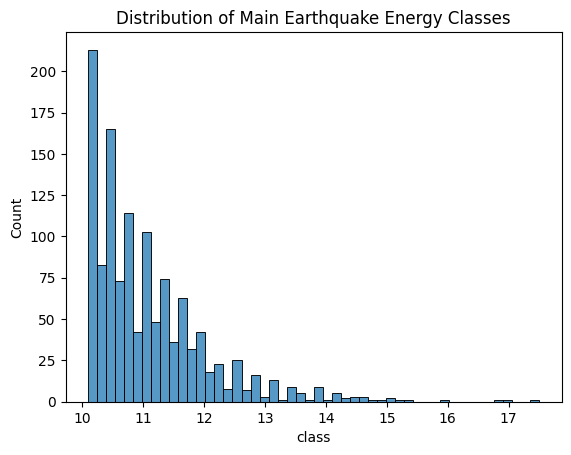

In [264]:
sns.histplot(train_df['class'], bins=50)
plt.title('Distribution of Main Earthquake Energy Classes')
plt.show()

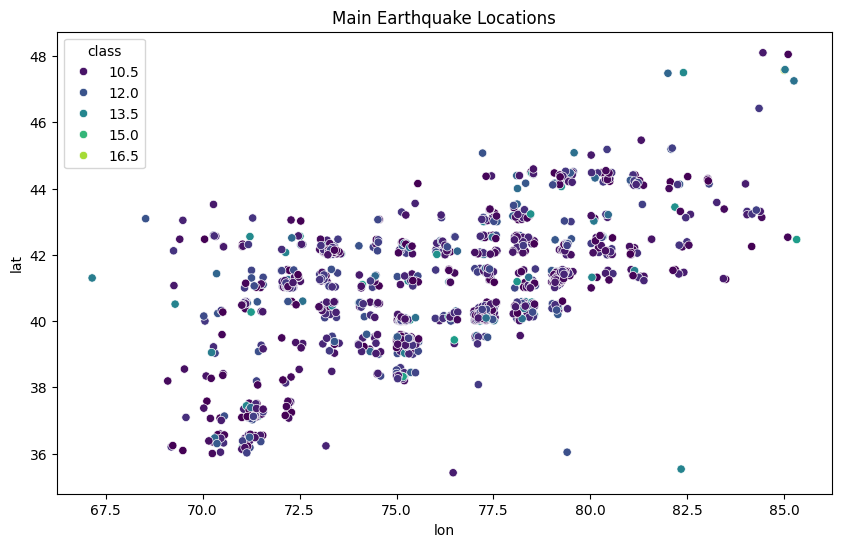

In [265]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='lon', y='lat', data=train_df, hue='class', palette='viridis')
plt.title('Main Earthquake Locations')
plt.show()

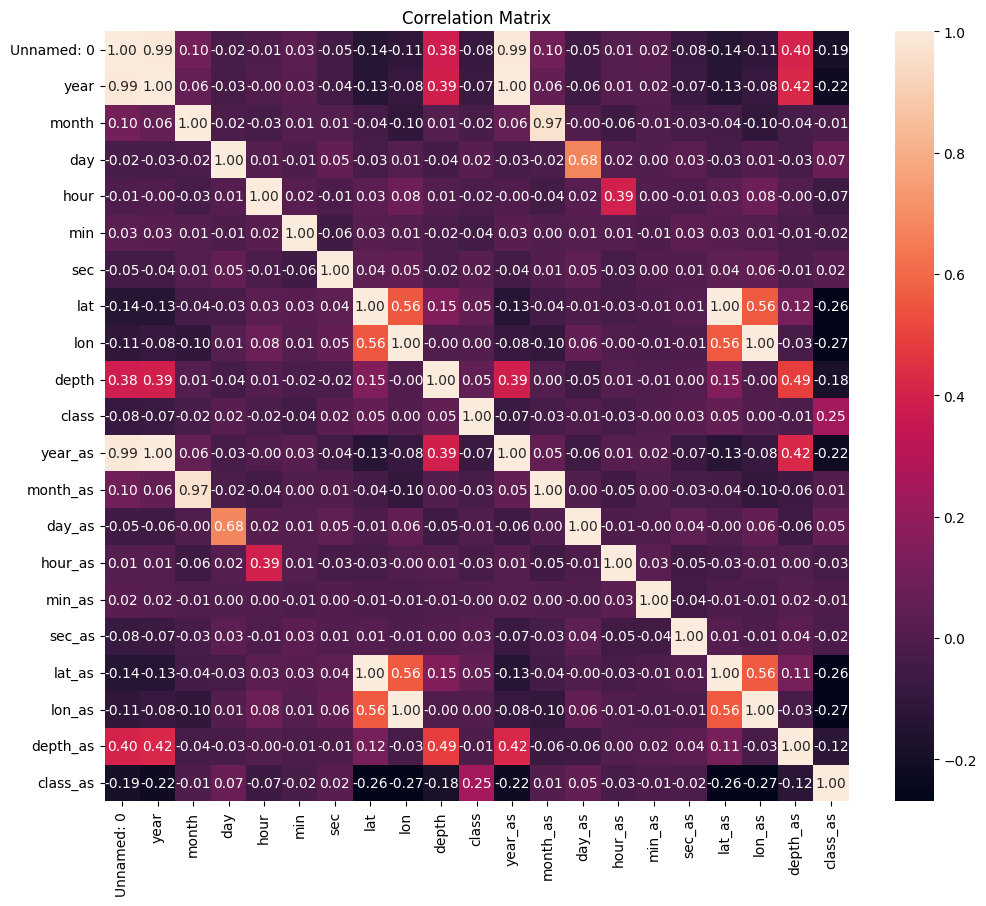

In [266]:
corr_matrix = train_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [267]:
train_df

,Unnamed: 0,year,month,day,hour,min,sec,lat,lon,depth,...,year_as,month_as,day_as,hour_as,min_as,sec_as,lat_as,lon_as,depth_as,class_as
0,0,1980,2,15,9,9,350,40.54,78.31,-1,...,1980,2,15,9,45,540,40.45,78.24,-1,7.7
1,1,1980,3,16,1,44,30,41.42,75.40,-1,...,1980,3,25,10,58,236,41.40,75.42,-1,8.7
2,2,1980,7,5,20,25,220,41.46,77.30,20,...,1980,7,5,21,41,335,41.56,77.25,5,7.3
3,3,1980,8,31,23,38,372,40.52,77.46,-1,...,1980,9,4,22,56,92,40.51,77.37,-1,7.3
4,4,1980,9,4,6,47,166,44.16,79.08,10,...,1980,9,14,9,16,160,44.18,79.30,-1,7.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,1245,2013,12,12,0,46,471,44.12,81.18,10,...,2013,12,12,6,1,159,44.14,81.42,5,6.2
1246,1246,2013,12,18,1,44,283,41.00,78.45,15,...,2013,12,24,10,6,388,41.04,78.44,10,7.5
1247,1247,2013,12,21,14,21,464,37.12,71.31,0,...,2013,12,22,1,24,74,37.23,71.17,5,9.3
1248,1248,2013,12,22,7,45,314,38.22,72.07,20,...,2013,12,26,8,26,227,38.47,72.14,0,7.7


In [268]:
train_df = train_df.rename(columns={'min': 'minute', 'sec': 'second'})
test_df = test_df.rename(columns={'min': 'minute', 'sec': 'second'})

In [269]:
train_df['datetime_eq'] = pd.to_datetime(train_df[['year', 'month', 'day', 'hour', 'minute', 'second']])
temp = train_df[['year', 'month', 'day', 'hour', 'minute', 'second']]
train_df[['year', 'month', 'day', 'hour', 'minute', 'second']] = train_df[['year_as', 'month_as', 'day_as', 'hour_as', 'min_as', 'sec_as']]
train_df['datetime_as'] = pd.to_datetime(train_df[['year', 'month', 'day', 'hour', 'minute', 'second']])
train_df[['year', 'month', 'day', 'hour', 'minute', 'second']] = temp

In [270]:
train_df['time_diff'] = (train_df['datetime_as'] - train_df['datetime_eq']).dt.total_seconds()

In [271]:
from geopy.distance import geodesic

def calculate_distance(row):
    coords_eq = (row['lat'], row['lon'])
    coords_as = (row['lat_as'], row['lon_as'])
    return geodesic(coords_eq, coords_as).kilometers

train_df['distance'] = train_df.apply(calculate_distance, axis=1)

In [272]:
def lat_lon_to_xyz(lat, lon):
    R = 6371
    lat_rad = np.radians(lat)
    lon_rad = np.radians(lon)
    x = R * np.cos(lat_rad) * np.cos(lon_rad)
    y = R * np.cos(lat_rad) * np.sin(lon_rad)
    z = R * np.sin(lat_rad)
    return x, y, z

train_df[['x_eq', 'y_eq', 'z_eq']] = train_df.apply(lambda row: lat_lon_to_xyz(row['lat'], row['lon']), result_type='expand', axis=1)
train_df[['x_as', 'y_as', 'z_as']] = train_df.apply(lambda row: lat_lon_to_xyz(row['lat_as'], row['lon_as']), result_type='expand', axis=1)

In [273]:
columns_to_drop = ['year', 'month', 'day', 'hour', 'minute', 'second',
                   'year_as', 'month_as', 'day_as', 'hour_as', 'min_as', 'sec_as',
                   'datetime_eq', 'datetime_as', 'lat_as', 'lon_as', 'depth_as', 'class_as', 'time_diff', 'Unnamed: 0', 'x_as', 'y_as', 'z_as', 'distance']
y = train_df[['time_diff', 'lat_as', 'lon_as', 'depth_as', 'class_as']]
X = train_df.drop(columns=columns_to_drop)

In [274]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [275]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)

y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)

In [276]:
xgb_model = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42))

In [277]:
import optuna

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),  # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),  # L2 regularization
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'tree_method': 'hist'  # Faster training
    }
    model = xgb.XGBRegressor(**params, objective='reg:squarederror', random_state=42)
    multi_output_model = MultiOutputRegressor(model)
    multi_output_model.fit(X_train_scaled, y_train_scaled)
    y_pred_scaled = multi_output_model.predict(X_val_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_val_original = scaler_y.inverse_transform(y_val_scaled)
    mae = mean_absolute_error(y_val_original, y_pred)
    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print("Best trial:", study.best_trial.params)

[I 2025-04-13 13:44:49,887] A new study created in memory with name: no-name-13725204-e78b-4d58-bb75-aac6cd75d2f4
[I 2025-04-13 13:44:53,640] Trial 0 finished with value: 44023.16827714693 and parameters: {'n_estimators': 967, 'max_depth': 4, 'learning_rate': 0.026746599125774276, 'subsample': 0.7537645799342408, 'colsample_bytree': 0.648199392479482, 'reg_alpha': 0.00029471919490570213, 'reg_lambda': 9.058752673495913, 'min_child_weight': 6, 'gamma': 0.14526113747716216}. Best is trial 0 with value: 44023.16827714693.
[I 2025-04-13 13:45:04,217] Trial 1 finished with value: 50633.60543462739 and parameters: {'n_estimators': 600, 'max_depth': 15, 'learning_rate': 0.2908646771922329, 'subsample': 0.5277678849236798, 'colsample_bytree': 0.7626700151431496, 'reg_alpha': 0.00685133195594506, 'reg_lambda': 1.2634832288400787e-05, 'min_child_weight': 2, 'gamma': 3.320295544894614e-08}. Best is trial 0 with value: 44023.16827714693.
[I 2025-04-13 13:45:11,056] Trial 2 finished with value: 454

Best trial: {'n_estimators': 554, 'max_depth': 15, 'learning_rate': 0.010781316654284832, 'subsample': 0.956667040139897, 'colsample_bytree': 0.6248349089613379, 'reg_alpha': 0.024296048581167993, 'reg_lambda': 0.00035124389323678667, 'min_child_weight': 7, 'gamma': 3.3442552215132723e-06}


In [278]:
best_params = study.best_params
best_model = MultiOutputRegressor(
    xgb.XGBRegressor(**best_params, objective='reg:squarederror', random_state=42),
    n_jobs=-1
)
best_model.fit(X_train_scaled, y_train_scaled)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.6248349089613379,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            gamma=3.3442552215132723e-06,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.010781316654284832,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=15,
                                            max_leaves=None, min_child_weight=7,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=554, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...),
                     n_jobs=-1)

In [279]:
y_pred_scaled = best_model.predict(X_val_scaled)

In [280]:
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_val_original = scaler_y.inverse_transform(y_val_scaled)

In [281]:
mae = mean_absolute_error(y_val_original, y_pred)
print(f"Validation MAE: {mae}")

Validation MAE: 42461.31495907817


In [282]:
# Convert date and time to datetime
test_df['datetime_eq'] = pd.to_datetime(test_df[['year', 'month', 'day', 'hour', 'minute', 'second']])

# Apply feature engineering steps
# Example: Calculate 'x_eq', 'y_eq', 'z_eq'

test_df[['x_eq', 'y_eq', 'z_eq']] = test_df.apply(lambda row: lat_lon_to_xyz(row['lat'], row['lon']), result_type='expand', axis=1)

# Drop unnecessary columns
test_ids = test_df['id_eq']  # Save IDs for submission
test_dfcopy = test_df
test_df = test_df.drop(columns=['id_eq', 'year', 'month', 'day', 'hour', 'minute', 'second', 'datetime_eq'])

In [283]:
print("Training features:", X_train.columns.tolist())
print("Test features:", test_df.columns.tolist())

Training features: ['lat', 'lon', 'depth', 'class', 'x_eq', 'y_eq', 'z_eq']
Test features: ['lat', 'lon', 'depth', 'class', 'x_eq', 'y_eq', 'z_eq']


In [284]:
X_test_scaled = scaler_X.transform(test_df)

In [285]:
y_test_pred_scaled = best_model.predict(X_test_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

In [286]:
# Extract predicted values
time_diff_pred = y_test_pred[:, 0]
lat_as_pred = y_test_pred[:, 1]
lon_as_pred = y_test_pred[:, 2]
depth_as_pred = y_test_pred[:, 3]
class_as_pred = y_test_pred[:, 4]

# Calculate aftershock datetime by adding time difference to main earthquake time
test_df['datetime_eq'] = pd.to_datetime(test_dfcopy[['year', 'month', 'day', 'hour', 'minute', 'second']])
test_df['datetime_as'] = test_df['datetime_eq'] + pd.to_timedelta(time_diff_pred, unit='s')

# Split datetime into required components
test_df['year_as'] = test_df['datetime_as'].dt.year
test_df['month_as'] = test_df['datetime_as'].dt.month
test_df['day_as'] = test_df['datetime_as'].dt.day
test_df['hour_as'] = test_df['datetime_as'].dt.hour
test_df['min_as'] = test_df['datetime_as'].dt.minute
test_df['sec_as'] = test_df['datetime_as'].dt.second + test_df['datetime_as'].dt.microsecond / 1e6

# Prepare submission DataFrame
submission_df = pd.DataFrame({
    'id_eq': test_ids,
    'year_as': test_df['year_as'],
    'month_as': test_df['month_as'],
    'day_as': test_df['day_as'],
    'hour_as': test_df['hour_as'],
    'min_as': test_df['min_as'],
    'sec_as': test_df['sec_as'],
    'lat_as': lat_as_pred,
    'lon_as': lon_as_pred,
    'depth_as': depth_as_pred,
    'class_as': class_as_pred
})

# Ensure correct data types
submission_df = submission_df.astype({
    'year_as': 'int32',
    'month_as': 'int32',
    'day_as': 'int32',
    'hour_as': 'int32',
    'min_as': 'int32',
    'sec_as': 'float64',
    'lat_as': 'float64',
    'lon_as': 'float64',
    'depth_as': 'float64',
    'class_as': 'float64'
})

In [287]:
submission_df.to_csv('submission.csv', index=False)

In [ ]:
import pandas as pd
import numpy as np
from io import StringIO
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler

def run_xgb_model(df):
    print("========== XGBoost MultiOutput Regressor ==========")
    # Define input columns (main event features) and target columns (aftershock features)
    input_cols = ['year', 'month', 'day', 'hour', 'min', 'sec', 'lat', 'lon', 'depth', 'class']
    target_cols = ['year_as', 'month_as', 'day_as', 'hour_as', 'min_as', 'sec_as', 'lat_as', 'lon_as', 'depth_as', 'class_as']

    X = df[input_cols]
    y = df[target_cols]

    # Perform a train-test split.
    # (With only 3 rows this is just illustrative. For real applications, use many more data points.)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    # Create the multioutput regressor using XGBoost.
    xgb_model = MultiOutputRegressor(XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42))
    xgb_model.fit(X_train, y_train)

    # Predict on test set
    y_pred = xgb_model.predict(X_test)

    # Evaluate using Mean Squared Error
    mse = mean_squared_error(y_test, y_pred)
    print("XGBoost Model Mean Squared Error:", mse)
    print("\nPredictions:")
    print(y_pred)
    print("\nGround Truth:")
    print(y_test.values)
def run_keras_model(df):
    print("\n========== Keras Neural Network Model ==========")
    # Define input and target columns as before
    input_cols = ['year', 'month', 'day', 'hour', 'min', 'sec', 'lat', 'lon', 'depth', 'class']
    target_cols = ['year_as', 'month_as', 'day_as', 'hour_as', 'min_as', 'sec_as', 'lat_as', 'lon_as', 'depth_as', 'class_as']

    X = df[input_cols].values
    y = df[target_cols].values

    # Neural networks usually perform better when inputs and outputs are scaled.
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)

    # Split into training and testing sets.
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.33, random_state=42)

    input_dim = X_train.shape[1]
    output_dim = y_train.shape[1]

    # Build a simple feed-forward neural network
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_dim))

    model.compile(loss='mse', optimizer='adam')

    # Train the model; the number of epochs can be adjusted as needed.
    model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=0)

    # Predict on the test set
    y_pred_scaled = model.predict(X_test)

    # Inverse-transform the scaled predictions back to the original scale
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_test_orig = scaler_y.inverse_transform(y_test)

    mse = mean_squared_error(y_test_orig, y_pred)
    print("Keras Model Mean Squared Error:", mse)
    print("\nPredictions:")
    print(y_pred)
    print("\nGround Truth:")
    print(y_test_orig)
def main():
# Load the data
    df = pd.read_csv('data/train.csv')
    print("Data Loaded:\n", df, "\n")

    # Run the XGBoost-based multioutput model
    run_xgb_model(df)

    # Run the Keras neural network model
    run_keras_model(df)

In [ ]:
main()